# SCAN Dataset

Each example in the SCAN dataset is aimed at converting a natural language command to a sequence of actions. 

$$ InputCommand \longrightarrow OutputSequence$$

Example: 

$$jump \qquad  thrice \longrightarrow JUMP \qquad  JUMP\qquad  JUMP$$

## Phrase Structure Grammar 

The input commands can be generated with a basic PS grammar starting from C and ending with U: 

1. C $\longrightarrow$ S and S
2. C $\longrightarrow$ S after S
3. C $\longrightarrow$ S
4. S $\longrightarrow$ V twice
5. S $\longrightarrow$ V thrice
6. S $\longrightarrow$ V
7. V $\longrightarrow$ D[1] opposite D[2]
8. V $\longrightarrow$ D[1] around D[2]
9. V $\longrightarrow$ D
10. V $\longrightarrow$ U
11. D $\longrightarrow$ U left
12. D $\longrightarrow$ U right
13. D $\longrightarrow$ turn left
14. D $\longrightarrow$ turn right
15. U $\longrightarrow$ walk
16. U $\longrightarrow$ run
17. U $\longrightarrow$ jump
18. U $\longrightarrow$ look

Where C=Full Command, S= Sentence Phrase, V= Verb Phrase, D= Direction Phrase, U= Verb

## Interpretation Function

[[walk]] = WALK 

[[jump]] = JUMP

[[run]]= RUN

[[look]]= LOOK

[[turn left]] = LTURN

[[turn right]] = RTURN

[[u left]]= LTURN [[u]]

[[u right]]= RTURN [[u]]

[[turn opposite left]] = LTURN LTURN

[[turn opposite right]] = RTURN RTURN

[[u opposite left]] = [[turn opposite left]] [[u]]

[[u opposite right]] = [[turn opposite right]] [[u]]

[[turn around left]] = LTURN LTURN LTURN LTURN

[[turn around right]] = RTURN RTURN RTURN RTURN

[[u around left]]= LTURN [[u]] LTURN [[u]] LTURN [[u]] LTURN [[u]]

[[u around right]]= RTURN [[u]] RTURN [[u]] RTURN [[u]] RTURN [[u]]

[[x twice]] = [[x]] [[x]]

[[x thrice]] = [[x]] [[x]] [[x]]

[[x1 and x2]] = [[x1]] [[x2]]

[[x1 after x2]] = [[x2]] [[x1]] 

In [1]:
from datasets import load_dataset

scan_simple = load_dataset("scan", "simple", trust_remote_code=True)
#scan_length = load_dataset("scan", "length", trust_remote_code=True)

In [217]:
scan_length['test'][5]

{'commands': 'jump around right and walk around left twice',
 'actions': 'I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK'}

In [206]:
num_actions = []
num_turns = []
for x in scan_simple['train']:
    command = x['commands']
    num_actions.append((sum([command.split().count(a) for a in actions.keys()])))
    num_turns.append((sum([command.split().count(a) for a in turns.keys()])))

print(max(num_actions))
print(max(num_turns))

2
2


In [277]:
scan_simple['train'][0]

{'commands': 'jump opposite right twice and turn opposite right thrice',
 'actions': 'I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT'}

In [278]:
scan_simple['train'][1]

{'commands': 'run opposite left after walk right',
 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}

## Building Causal Model

Ideal Causal Algorithm: 

1. Layer 0: For a given command like "jump thrice and turn left", get list of leaf nodes.
2. Layer 1: Get the phrase divisions based on "and" and "after" 
3. Layer 2: Use interpretation function to get an interpretation for each node
4. Layer 3: Use variable binding to remove all variables
5. Layer 4: Get final action sequence

In [3]:
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK"
    }

## around and opposite behave differently ##
turns = {
    "around": "yyyy",
    "opposite": "yy"
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT"
}

nums = {
    "twice": "xx",
    "thrice": "xxx"
}

classes = [actions, turns, directions, nums]

turns_inv = {v: k for k, v in turns.items()}
nums_inv = {v: k for k, v in nums.items()}


In [ ]:
checklist = [
    'jump thrice and turn left',
    'run opposite left after walk right',
    'walk after run around right twice',
    'jump around right and walk around left twice',
    'run around left thrice after walk left twice',
    'jump opposite right twice and turn opposite right thrice',
    'run around left thrice after walk left twice',
    'turn around right twice after run around right thrice'
    'walk opposite left',
    ]

In [506]:
# layer 0: get list of leaf nodes
#command= "jump thrice and turn left"
#command = "run opposite left after walk right"
#command = 'walk after run around right twice'
#command = 'jump around right and walk around left twice'
#command = 'run around left thrice after walk left twice'
#command = 'jump opposite right twice and turn opposite right thrice'
#command = 'run around left thrice after walk left twice'
#command = 'turn around right twice after run around right thrice'
command = 'walk opposite left'
l0=command.split()
l0 = list(filter(lambda a: a != 'turn', l0))
print(l0)

['walk', 'opposite', 'left']


In [507]:
# layer 1: get phrase divisions
if 'and' in l0:
    # maintain order of command
    l11=l0[:l0.index("and")] 
    l12= l0[l0.index("and")+1:]
elif 'after' in l0:
    # reverse order of command
    l11= l0[l0.index("after")+1:]
    l12=l0[:l0.index("after")] 
else:
    l11=l0
    l12=[]

l1=[l11,l12]
print(l1)

[['walk', 'opposite', 'left'], []]


In [508]:
# layer 2: apply interpretation function depending on word class
l21 = [classes[[w in c for c in classes].index(True)][w] for w in l11]
l21 = list(reversed(l21))

l22 = [classes[[w in c for c in classes].index(True)][w] for w in l12]
l22 = list(reversed(l22))

l2=[l21,l22]
print(l2)


[['I_TURN_LEFT', 'yy', 'I_WALK'], []]


In [7]:
# layer 3: variable binding

def variable_binding(l):

    if not any(x in l for x in list(turns_inv.keys())+list(nums_inv.keys())):
        return [' '.join(l)]

    for n, v in turns_inv.items():
        if n not in l:
            continue
        ind = l.index(n)
        op = l[ind]
        if v == 'around':
            if l[-1] in set(actions.values()):
                dec_act = (l[ind-1]+' '+l[-1]+' ')*len(op)
            else:
                dec_act = (l[ind-1]+' ')*len(op)
            dec_act = dec_act.strip()
            l[ind] = dec_act
        else:
            if l[-1] in set(actions.values()):
                dec_act = (l[ind-1]+' ')*len(op) + l[-1]
            else:
                dec_act = (l[ind-1]+' ')*len(op)

            dec_act = dec_act.strip()
            l[ind] = dec_act
            
        l.pop(ind-1)
        if l[-1] in set(actions.values()):
            l.pop(-1)

            
    for n, v in nums_inv.items():
        if n not in l:
            continue
        ind = l.index(n)
        op = l[ind]
        dec_act = ((' '.join(l[ind+1:])+' ')*len(op)).strip()
        l[ind] = dec_act

    return l[:1]

In [510]:

l31 = variable_binding(l21)

l32 = variable_binding(l22)


l3=[l31,l32]
print(l3)

[['I_TURN_LEFT I_TURN_LEFT I_WALK'], ['']]


In [ ]:
{'commands': 'jump opposite right twice and turn opposite right thrice',
 'actions': 'I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT'}

In [511]:
# layer 4: action sequence output
sequence = ' '.join([item for sublist in l3 for item in sublist])
print(sequence)

I_TURN_LEFT I_TURN_LEFT I_WALK 


In [516]:
l32[0] == ''

True

#### Causal Model Function

In [8]:
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK"
    }

## around and opposite behave differently ##
turns = {
    "around": "yyyy",
    "opposite": "yy"
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT"
}

nums = {
    "twice": "xx",
    "thrice": "xxx"
}

classes = [actions, turns, directions, nums]

turns_inv = {v: k for k, v in turns.items()}
nums_inv = {v: k for k, v in nums.items()}


def causal_model(command):

    l0=command.split()
    l0 = list(filter(lambda a: a != 'turn', l0))

    # layer 1: get phrase divisions
    if 'and' in l0:
        # maintain order of command
        l11=l0[:l0.index("and")] 
        l12= l0[l0.index("and")+1:]
    elif 'after' in l0:
        # reverse order of command
        l11= l0[l0.index("after")+1:]
        l12=l0[:l0.index("after")] 
    else:
        l11=l0
        l12=[]

    l1=[l11,l12]

    # layer 2: apply interpretation function depending on word class
    l21 = [classes[[w in c for c in classes].index(True)][w] for w in l11]
    l21 = list(reversed(l21))

    l22 = [classes[[w in c for c in classes].index(True)][w] for w in l12]
    l22 = list(reversed(l22))

    l2=[l21,l22]

    # layer 3: variable binding
    l31 = variable_binding(l21)
    l32 = variable_binding(l22)

    l3=[l31,l32]

    # layer 4: action sequence output
    sequence = ' '.join([item for sublist in l3 for item in sublist])
    
    return sequence.strip()

In [10]:
count = 0

for x in scan_simple['test']:
    command = x['commands']
    label = x['actions']
    output = causal_model(command)
    if label != output:
        print(command)
        print(label)
        print(output)
        break


In [498]:
label

'I_TURN_LEFT I_TURN_LEFT I_WALK'

In [499]:
output

'I_TURN_LEFT I_TURN_LEFT I_WALK '

In [3]:
from pyvene import CausalModel

# Assumptions?
# Longest command is 9 words : https://arxiv.org/pdf/1711.00350

actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK",
    "turn": "",
    # dummy placeholder to pad input
    "": "",
}

turns = {
    "around": "yyyy",
    "opposite": "yy",
    # dummy placeholder to pad input
    "": "",
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT",
    # dummy placeholder to pad input
    "": "",
}

nums = {
    "twice": "xx",
    "thrice": "xxx",
    # dummy placeholder to pad input
    "": "",
}

conjs = ["and", "after"]

# all mappings together
classes = [actions, turns, directions, nums]
# inverted turns and directions mappings
turns_inv = {v: k for k, v in turns.items()}
nums_inv = {v: k for k, v in nums.items()}

# causal model variables
# longest command is 9 words : https://arxiv.org/pdf/1711.00350
variables = [
    # leaves
    "act1", "trn1", "dir1", "num1",
    "conj",
    "act2", "trn2", "dir2", "num2",
]

# causal model functions
functions = {
    # leaves
    "act1": lambda x: actions(x),
    "act2": lambda x: actions(x),

    "trn1": lambda x: turns(x),
    "trn2": lambda x: turns(x),

    "dir1": lambda x: directions(x),
    "dir2": lambda x: directions(x),

    "num1": lambda x: nums(x),
    "num2": lambda x: nums(x),

    "conj": lambda x: x,

    # combining turn and and direction
    # need to check for EMPTY
    # "trn1_dir1": lambda t, d:

}

# values of nodes
values = {}
values["act1"] = list(actions.values())
values["act2"] = list(actions.values())

values["trn1"] = list(turns.values())
values["trn2"] = list(turns.values())

values["dir1"] = list(directions.values())
values["dir2"] = list(directions.values())

values["num1"] = list(nums.values())
values["num2"] = list(nums.values())

values["conj"] = conjs

# parents
parents = {v: [] for v in variables}

# a dictionary with nodes as keys and positions as values
pos = {
    "act1": (4, 5),
    "trn1": (2, 23),
    "dir1": (13, 4),
    "num1": (12, 6),
    "conj": (5, 7),
    "act2": (6, 2),
    "trn2": (17, 11),
    "dir2": (8, 15),
    "num2": (9, 0),
}

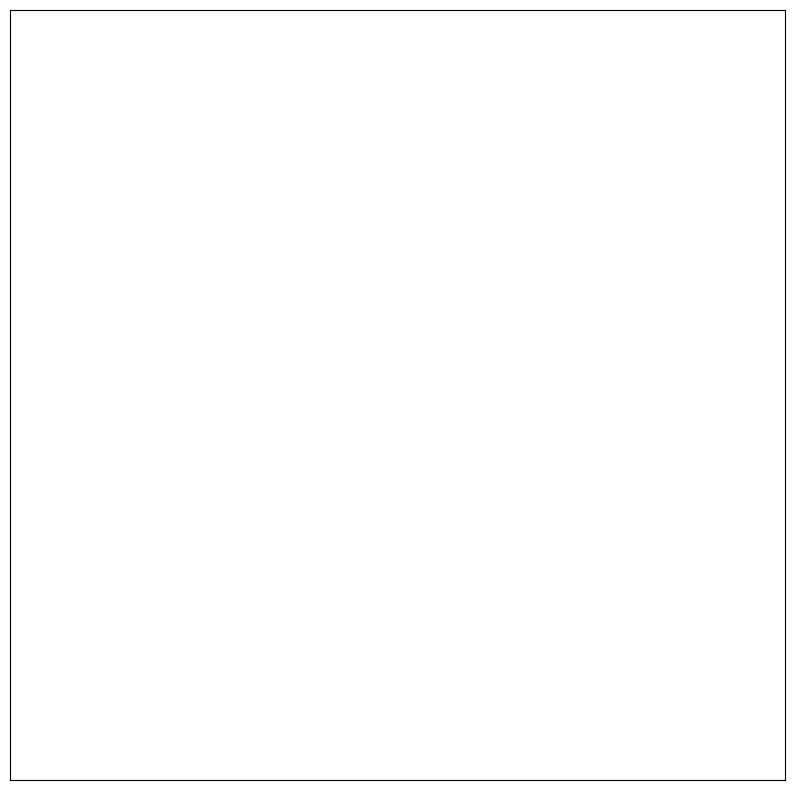

Timesteps: {'act1': 0, 'act2': 0, 'conj': 0, 'dir1': 0, 'dir2': 0, 'num1': 0, 'num2': 0, 'trn1': 0, 'trn2': 0}


In [4]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()
print("Timesteps:", causal_model.timesteps)

In [5]:
causal_model